# Predicting Insurance Charges - Using Machine Learning

![](image.jpg)

## Dataset Summary
`insurance.csv` is the dataset that we will be using to train our model, while `validation_data.csv` will be the 'unseen' dataset to test our model accuracy.

The given description of the data is as follows:

| Column    | Data Type | Description                                                      |
|-----------|-----------|------------------------------------------------------------------|
| `age`       | int       | Age of the primary beneficiary.                                  |
| `sex`       | object    | Gender of the insurance contractor (male or female).             |
| `bmi`       | float     | Body mass index, a key indicator of body fat based on height and weight. |
| `children`  | int       | Number of dependents covered by the insurance plan.              |
| `smoker`    | object    | Indicates whether the beneficiary smokes (yes or no).            |
| `region`    | object    | The beneficiary's residential area in the US, divided into four regions. |
| `charges`   | float     | Individual medical costs billed by health insurance.             |


Observing the summary statistics, missing value count and unique value list, the data will need to be cleaned for:
- Missing values (66 count out of total)
- Inconsistent input of the same values (eg. "male", "man", "M" is referring to the same gender)
- Integer values stored as string (eg. charges containing $-symbol is stored as string).
- Unexpected negative values in `age` and `children` column.

In [121]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score , KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import seaborn as sns
import matplotlib.pyplot as plt


# Loading the insurance dataset
insurance_data_path = 'insurance.csv'
validation_data_path = 'validation_dataset.csv'
insurance = pd.read_csv(insurance_data_path)
validation = pd.read_csv(validation_data_path)
# insurance.head()

In [98]:
# Summary of the data
summary = insurance.describe(include='all')

# Checking for missing values
missing_values = insurance.isnull().sum()

# Checking for unique values in categorical columns
unique_values = {col: insurance[col].unique() for col in insurance.select_dtypes(include=['object']).columns}


Summary Statiscs on `insurance.csv`:

In [99]:
display(summary)

,age,sex,bmi,children,smoker,region,charges
count,1272.000000,1272,1272.000000,1272.000000,1272,1272,1284
unique,NaN,6,NaN,NaN,2,8,1272
top,NaN,male,NaN,NaN,no,Southeast,$nan
freq,NaN,517,NaN,NaN,1013,172,12
mean,35.214623,NaN,30.560550,0.948899,NaN,NaN,NaN
std,22.478251,NaN,6.095573,1.303532,NaN,NaN,NaN
min,-64.000000,NaN,15.960000,-4.000000,NaN,NaN,NaN
25%,24.750000,NaN,26.180000,0.000000,NaN,NaN,NaN
50%,38.000000,NaN,30.210000,1.000000,NaN,NaN,NaN
75%,51.000000,NaN,34.485000,2.000000,NaN,NaN,NaN


Missing Value Count:

In [100]:
display(missing_values)

age         66
sex         66
bmi         66
children    66
smoker      66
region      66
charges     54
dtype: int64

List of Unique Values:

In [101]:
display(unique_values)

{'sex': array(['female', 'male', 'woman', 'F', 'man', nan, 'M'], dtype=object),
 'smoker': array(['yes', 'no', nan], dtype=object),
 'region': array(['southwest', 'Southeast', 'southeast', 'northwest', 'Northwest',
        'Northeast', 'northeast', 'Southwest', nan], dtype=object),
 'charges': array(['16884.924', '1725.5523', '$4449.462', ..., '$1629.8335',
        '2007.945', '29141.3603'], dtype=object)}

## Data Cleaning

Correction will be made to the existing data first before handling missing values, as we will utilize them as a measure to input the missing values (eg. using mean value). The following correction is made:

1. Inconsistent input 
    - `sex`: 'man' and 'M' is replaced with 'male'; while 'woman' and 'F' is replaced with 'female'
    - `region`: inconsistenc capitalisation of letter. Make all value small-cap.
    - `charges`: remove dollar ('$') signs/ convert them into numerical value.
    
2. Unexpected negative value:
    - `age`: transform all negative age into positive integer by applying the factor -1
    - `children`: transform all negative children count into positive integer by applying the factor -1

In [102]:
# Make a copy of the data
insurance_cleaned = insurance.copy()

# Transform negative age by applying -1 factor
insurance_cleaned['age'] = insurance_cleaned['age'].apply(lambda x: -x if x < 0 else x)

# Replace 'M' and 'man' with 'male'; 'F' and 'woman' with 'female'
insurance_cleaned['sex'] = insurance_cleaned['sex'].replace({'M': 'male', 'man': 'male', 'F': 'female', 'woman': 'female'})

# Replace any capital letters in region with small cap
insurance_cleaned['region'] = insurance_cleaned['region'].str.lower()

# Transform negative children value by applying -1 factor
insurance_cleaned['children'] = insurance_cleaned['children'].apply(lambda x: -x if x < 0 else x)

# Convert 'charges' column into numerical by removing the '$' sign
insurance_cleaned['charges'] = insurance_cleaned['charges'].replace(r'[\$,]', '', regex=True).astype(float)

In [103]:
# Summary statistics
summary_stats = insurance_cleaned.describe()

# Count of missing rows
missing_row_count = insurance_cleaned.isnull().sum()

# Percentage of missing data vs overall data
missing_percentage = (missing_row_count / len(insurance_cleaned)) * 100

# Unique values in each column
unique_values = {col: insurance_cleaned[col].unique() for col in insurance_cleaned.select_dtypes(include=['object']).columns}

# summary_stats, missing_row_count, missing_percentage, unique_values

Re-running the summary statistics and filtering the unique value for categorical column - we can see that all the input are consistent and within reasonable range. We can now proceed with handling missing values.

We propose to handle the missing values as follows:
- `age`: use mean value
- `sex`: use most frequent value
- `children`: use 0 (most frequent value)
- `smoker`: use most frequent value
- `region`: randomly input based on existing data, while maintaining the distribution

Once the missing value for `age`, `sex`, `children`, `somker` and `region` is populated, we will group the data based on these profile and use the average to populate the missing `bmi` and `charges`.

In [104]:
# Replace missing age values with the average age (rounded to nearest integer)
average_age = round(insurance_cleaned['age'].mean())
insurance_cleaned['age'] = insurance_cleaned['age'].fillna(average_age)

# Replace missing sex values with the most frequent value
most_frequent_sex = insurance_cleaned['sex'].mode()[0]
insurance_cleaned['sex'] = insurance_cleaned['sex'].fillna(most_frequent_sex)

# Replace missing children values with 0
insurance_cleaned['children'] = insurance_cleaned['children'].fillna(0)

# Replace missing smoker values with the most frequent value
most_frequent_smoker = insurance_cleaned['smoker'].mode()[0]
insurance_cleaned['smoker'] = insurance_cleaned['smoker'].fillna(most_frequent_smoker)

In [105]:
# Calculate the distribution of the 'region' column
region_distribution = insurance_cleaned['region'].value_counts(normalize=True)

# Function to fill missing 'region' values based on the distribution
def fill_missing_region(row, region_distribution):
    if pd.isnull(row['region']):
        row['region'] = np.random.choice(region_distribution.index, p=region_distribution.values)
    return row

# Apply the function to fill missing 'region' values
insurance_cleaned = insurance_cleaned.apply(lambda row: fill_missing_region(row, region_distribution), axis=1)

From the missing value count, we observed there is no more missing values except for `bmi` and `charges` column which we will process next.

In [106]:
# Filter rows with missing values in any column
rows_with_missing_values = insurance_cleaned[insurance_cleaned.isnull().any(axis=1)]

# Identify the columns with missing values for each row
missing_row_count = insurance_cleaned.isnull().sum()

display(missing_row_count)

age          0
sex          0
bmi         66
children     0
smoker       0
region       0
charges     66
dtype: int64

We populate the missing value for `bmi` and `charges` using the average calculated based on their "`age`-`sex`-`children`-`smoker`-`region`" profile. 

We group the age profile based on 10-years interval (to avoid having too many unique age grouping):


In [107]:
# Create age groups based on 10-year intervals
insurance_cleaned['age_group'] = pd.cut(insurance_cleaned['age'], bins=range(0, 101, 10), right=False)

# Convert the age_group intervals to strings for JSON serialization
insurance_cleaned['age_group'] = insurance_cleaned['age_group'].astype(str)

# Group by age_group, sex, children, smoker status, and region, then compute the average bmi, average charges, and count
grouped_data = insurance_cleaned.groupby(['age_group', 'sex', 'children', 'smoker', 'region']).agg({
    'bmi': 'mean',
    'charges': 'mean',
    'age_group': 'count'  # Using 'age_group' to count the number of entries in each group
}).rename(columns={'age_group': 'count'}).reset_index()

# Display the grouped data with average bmi, average charges, and count
grouped_data.head()

,age_group,sex,children,smoker,region,bmi,charges,count
0,"[10, 20)",female,0.0,no,northeast,31.706250,4227.596881,12
1,"[10, 20)",female,0.0,no,northwest,34.352000,2133.792280,5
2,"[10, 20)",female,0.0,no,southeast,34.558333,3489.826933,12
3,"[10, 20)",female,0.0,no,southwest,26.414286,1739.758857,7
4,"[10, 20)",female,0.0,yes,northeast,21.660000,14283.459400,1


There is no longer missing values observed and the value range looks reasonable - we will use this data for model training:

In [108]:
# Function to fill missing values based on the average of the group
def fill_missing_values(row, grouped_data):
    if pd.isnull(row['bmi']) or pd.isnull(row['charges']):
        group = grouped_data[
            (grouped_data['age_group'] == row['age_group']) &
            (grouped_data['sex'] == row['sex']) &
            (grouped_data['children'] == row['children']) &
            (grouped_data['smoker'] == row['smoker'])
        ]
        if not group.empty:
            if pd.isnull(row['bmi']):
                row['bmi'] = group['bmi'].values[0]
            if pd.isnull(row['charges']):
                row['charges'] = group['charges'].values[0]
    return row

# Apply the function to fill missing values
insurance_cleaned = insurance_cleaned.apply(lambda row: fill_missing_values(row, grouped_data), axis=1)

# Drop the 'age_group' column once missing value is inputed
insurance_cleaned.drop('age_group', axis=1, inplace=True)

In [109]:
# Calculate summary statistics for the insurance_cleaned dataframe
summary_stats = insurance_cleaned.describe()

# Check for missing values in the insurance_cleaned dataframe
missing_values = insurance_cleaned.isnull().sum()

# Display the summary statistics and missing values
display(summary_stats)
print(" ") 
display(missing_values)

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.319133,30.518267,1.026158,13132.420288
std,13.712911,5.989130,1.190867,12000.588693
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.220000,0.000000,4828.586213
50%,39.000000,30.210000,1.000000,9237.375800
75%,51.000000,34.210000,2.000000,15766.537613
max,64.000000,53.130000,5.000000,63770.428010


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

## Data Transformation on Categorical Data
We perform one-hot encoding for categorical data such as sex and region.

In [110]:
# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')

# Perform one-hot encoding on 'sex', 'region', and 'smoker' columns
encoded_features = encoder.fit_transform(insurance_cleaned[['sex', 'region', 'smoker']])

# Create a DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['sex', 'region', 'smoker']))

# Concatenate the original dataframe with the encoded features
insurance_cleaned = pd.concat([insurance_cleaned, encoded_df], axis=1)

# Drop the original 'sex', 'region', and 'smoker' columns
insurance_cleaned.drop(['sex', 'region', 'smoker'], axis=1, inplace=True)

In [111]:
insurance_cleaned.head()

,age,bmi,children,charges,sex_male,region_northwest,region_southeast,region_southwest,smoker_yes
0,19.0,27.900,0.0,16884.92400,0.0,0.0,0.0,1.0,1.0
1,18.0,33.770,1.0,1725.55230,1.0,0.0,1.0,0.0,0.0
2,28.0,33.000,3.0,4449.46200,1.0,0.0,1.0,0.0,0.0
3,33.0,22.705,0.0,21984.47061,1.0,1.0,0.0,0.0,0.0
4,32.0,28.880,0.0,3866.85520,1.0,1.0,0.0,0.0,0.0


## Visualisation for Initial insights
Based on the pair plot for `charges`, we might expect some positive linear relationship between `charges` and `age`; and also `charges` and `bmi`. We would also expect `smoker` status to influence the magnitude of charges - that is those who smoke tend to have higher charge in general.

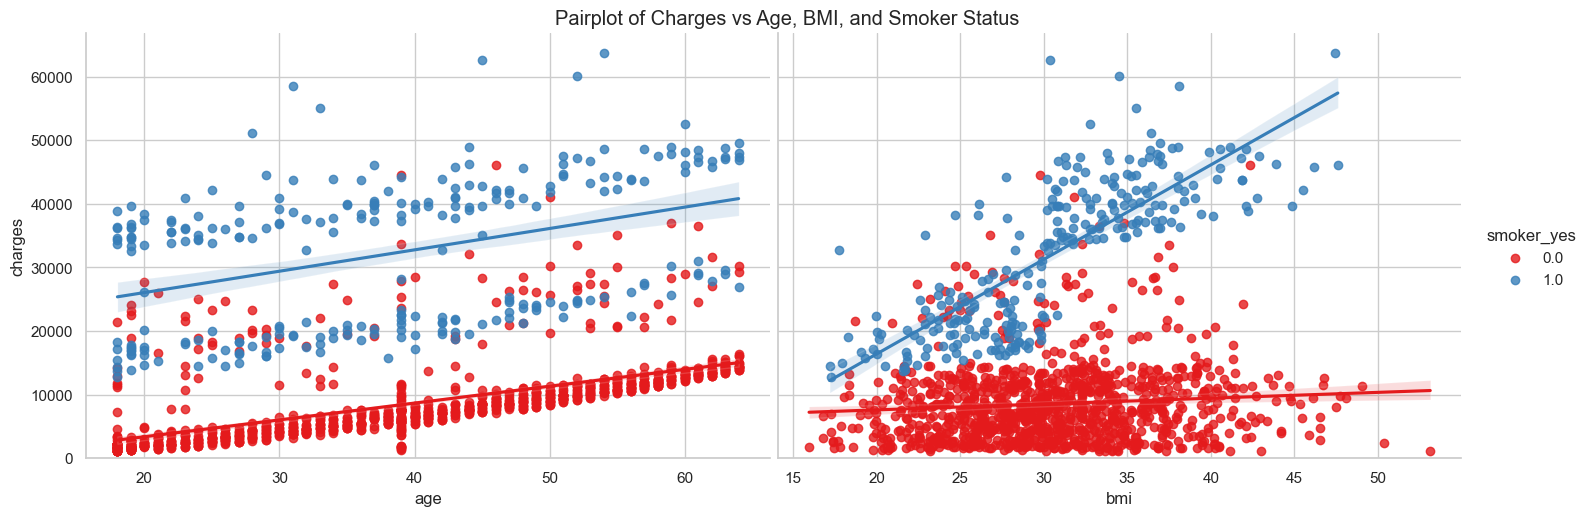

In [112]:
# Prepare the data for the pairplot
pairplot_data = insurance_cleaned[['charges', 'age', 'bmi', 'smoker_yes']]

# Set Seaborn style
sns.set(style="whitegrid")

# Create the pairplot
pairplot = sns.pairplot(pairplot_data, 
                        y_vars='charges', 
                        x_vars=['age', 'bmi'], 
                        hue='smoker_yes', 
                        kind='reg', 
                        palette='Set1',
                        height=5,
                        aspect=1.5)

# Add titles and adjust layout for better readability
pairplot.fig.suptitle('Pairplot of Charges vs Age, BMI, and Smoker Status', y=1.02)
pairplot.set(ylim=(0, None))

# Show the plot
plt.show()

## Model Fitting on Training Dataset

Our approach to model fitting will be as follows:
- we will fit a few model for comparison, namely, **Linear Regression** model, **Random Forest** model and **Gradient Boosting**.
- we will use 10-fold cross-validation and use r-squared score to determine the performance of our model.

Model results:
- The mean-score for regression model is 0.72.
- The mean-score for random forest model is 0.79.
- both model show good score well above the 0.65 threshold. 

### Results for Linear Regression

| Mean R2 Score | Std R2 Score | 10-fold cross-validation result |
|---------------|--------------|-------------------------------- |
|  0.72318      | 0.04055      | [0.71621793, 0.77631477, 0.7008166 , 0.65794208, 0.6989878 , 0.6918553 , 0.73338574, 0.75921349, 0.70078009, 0.79628937]|


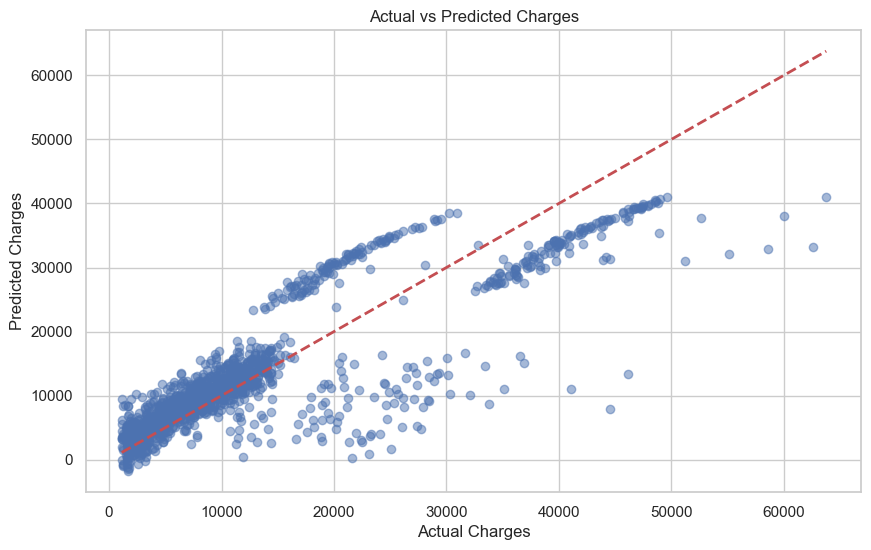

In [113]:
# Define the features and target variable
X = insurance_cleaned.drop('charges', axis=1)
y = insurance_cleaned['charges']

# Initialize the Linear Regression model
model = LinearRegression()

# Perform 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=1)
cv_scores = cross_val_score(model, X, y, cv=kf)

# Fit the model on the entire dataset
model.fit(X, y)

# Predict the charges
y_pred = model.predict(X)

# Plot the actual vs predicted charges
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs Predicted Charges')
plt.show()

# calculate the mean and standard deviation of the r-squared for CV
mean_r2 = np.mean(cv_scores)
std_r2 = np.std(cv_scores)

r2_score = mean_r2

# cv_scores, mean_r2, std_r2

### Results for Random Forest Regressor

| Mean R2 Score | Std R2 Score | 10-fold cross-validation result |
|---------------|--------------|-------------------------------- |
|  0.794777      | 0.039048      | [0.80221499, 0.82472613, 0.80263251, 0.74656096, 0.75195841, 0.73216968, 0.82461951, 0.78371195, 0.81585312, 0.86332322]|


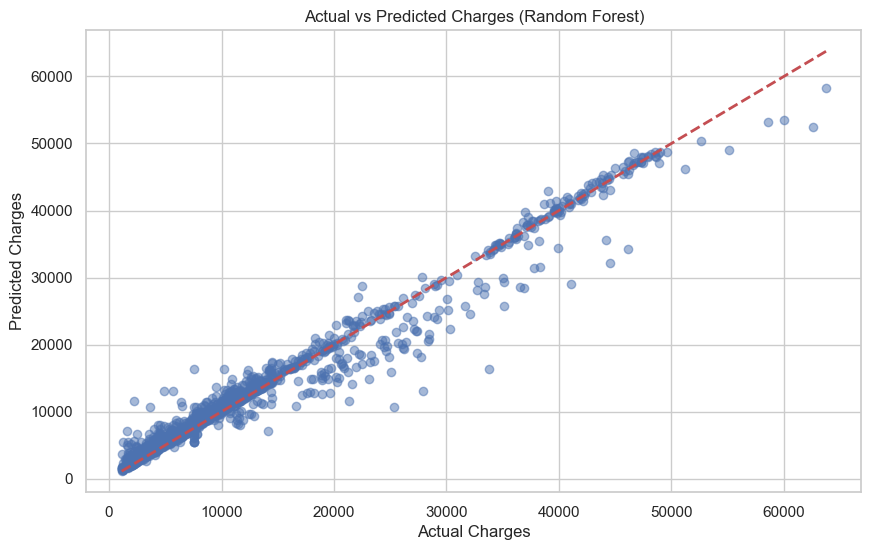

(array([0.80221499, 0.82472613, 0.80263251, 0.74656096, 0.75195841,
        0.73216968, 0.82461951, 0.78371195, 0.81585312, 0.86332322]),
 np.float64(0.7947770487033577),
 np.float64(0.03904827176265199))

In [114]:
# Initialize the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=1)

# Perform 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=1)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=kf)

# Fit the model on the entire dataset
rf_model.fit(X, y)

# Predict the charges
y_pred_rf = rf_model.predict(X)

# Plot the actual vs predicted charges
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred_rf, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs Predicted Charges (Random Forest)')
plt.show()

# Calculate the mean and standard deviation of the r-squared for CV
mean_r2_rf = np.mean(cv_scores_rf)
std_r2_rf = np.std(cv_scores_rf)
r2_score_rf = mean_r2_rf

# cv_scores_rf, mean_r2_rf, std_r2_rf

### Results for Gradient Boosting Regressor

| Mean R2 Score | Std R2 Score | 10-fold cross-validation result |
|---------------|--------------|-------------------------------- |
|  0.821310     | 0.0309577      | [0.82739897, 0.84607382, 0.8349181 , 0.77094155, 0.78173019, 0.79061051, 0.83495207, 0.82358903, 0.82233257, 0.88055515]|


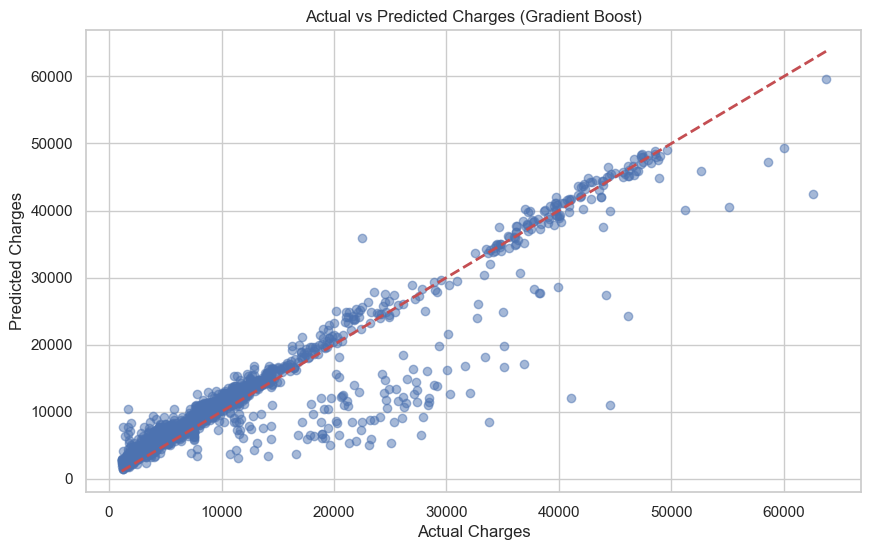

In [125]:
# Initialize the Random Forest Regressor model
gb_model = GradientBoostingRegressor(random_state=1)

# Perform 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=1)
cv_scores_gb = cross_val_score(gb_model, X, y, cv=kf)

# Fit the model on the entire dataset
gb_model.fit(X, y)

# Predict the charges
y_pred_gb = gb_model.predict(X)

# Plot the actual vs predicted charges
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred_gb, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs Predicted Charges (Gradient Boost)')
plt.show()

# Calculate the mean and standard deviation of the r-squared for CV
mean_r2_gb = np.mean(cv_scores_gb)
std_r2_gb = np.std(cv_scores_gb)
r2_score_gb = mean_r2_gb

#cv_scores_gb, mean_r2_gb, std_r2_gb

### Comparison Across Models
The score for the three models are summarised below:

| Model | Mean R2 Score | 
|-------|--------|
| Linear Regresson        | 0.72318 |
| Random Forest Regressor | 0.79477 |
| Gradient Boost Regressor| 0.82131 |

The Gradient Boost Regressor model demonstrated strong performance with the highest R-squared value of 0.82 among all three models, indicating it explains a significant portion of the variance in the insurance charges.


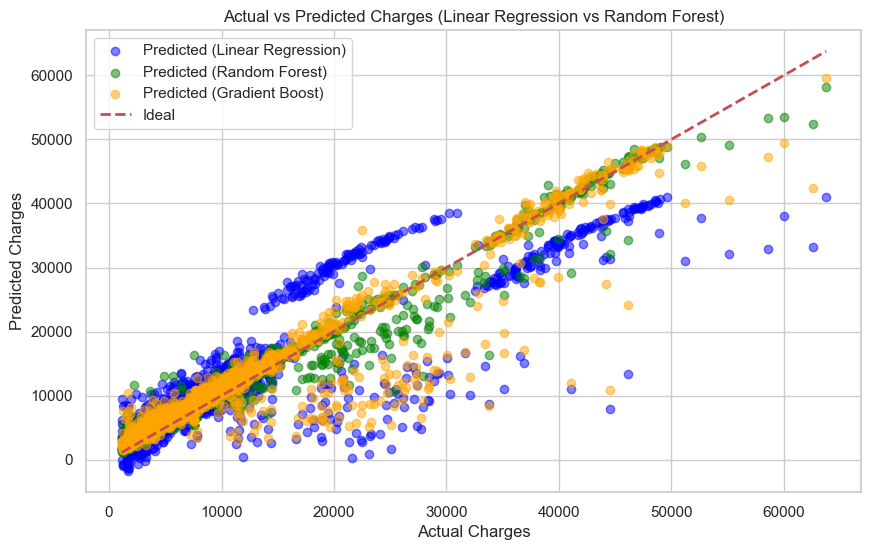

In [130]:
plt.figure(figsize=(10, 6))

# Actual vs Predicted (Linear Regression)
plt.scatter(y, y_pred, alpha=0.5, label='Predicted (Linear Regression)', color='blue')

# Actual vs Predicted (Random Forest)
plt.scatter(y, y_pred_rf, alpha=0.5, label='Predicted (Random Forest)', color='green')

# Actual vs Predicted (gradient boost Regression)
plt.scatter(y, y_pred_gb, alpha=0.5, label='Predicted (Gradient Boost)', color='orange')

# Ideal line
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Ideal')

plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs Predicted Charges (Linear Regression, Gradient Boost, Random Forest)')
plt.legend()
plt.show()

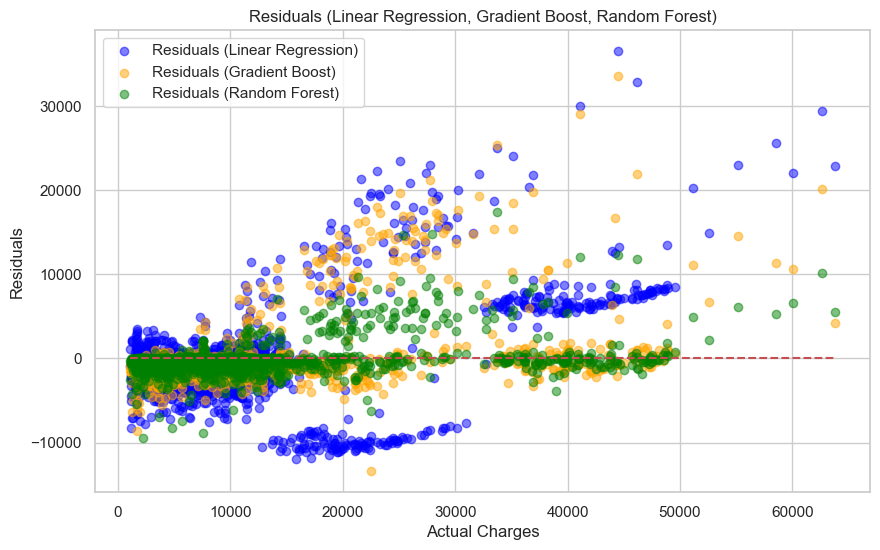

In [131]:
plt.figure(figsize=(10, 6))

# Residuals for Linear Regression
plt.scatter(y, y - y_pred, alpha=0.5, label='Residuals (Linear Regression)', color='blue')

# Residuals for Gradient Boosting
plt.scatter(y, y - y_pred_gb, alpha=0.5, label='Residuals (Gradient Boost)', color='orange')

# Residuals for Random Forest
plt.scatter(y, y - y_pred_rf, alpha=0.5, label='Residuals (Random Forest)', color='green')

plt.hlines(y=0, xmin=y.min(), xmax=y.max(), color='r', linestyles='dashed')
plt.xlabel('Actual Charges')
plt.ylabel('Residuals')
plt.title('Residuals (Linear Regression, Gradient Boost, Random Forest)')
plt.legend()
plt.show()

## Feature-Importance
- Both Random Forest and Gradient Boost models indicates three features that is important to make prediction on the `charges` - `smoker` status, `bmi` score and `age` (ordered by most significance).

- Linear regression model givest significant weight to a `smoker` status as the most important predictor. 


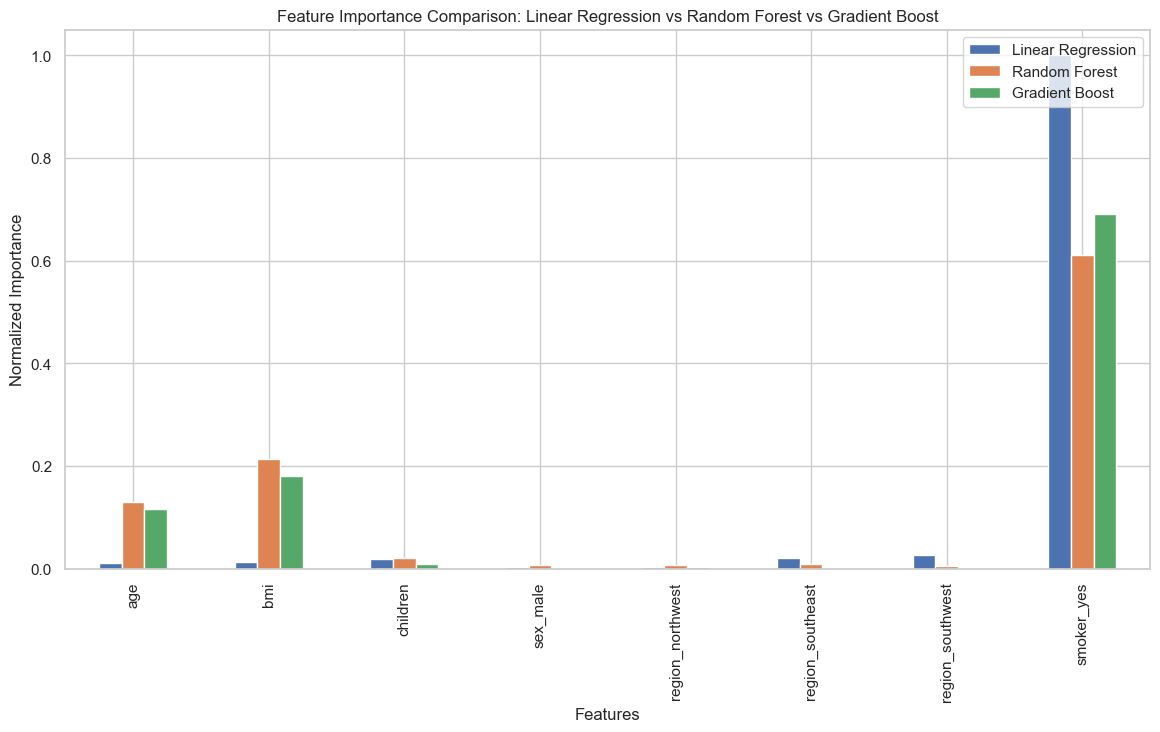

In [132]:
# Get feature importances for Linear Regression
lr_feature_importance = np.abs(model.coef_)
lr_feature_importance = lr_feature_importance / lr_feature_importance.max()  # Normalize

# Get feature importances for Random Forest
rf_feature_importance = rf_model.feature_importances_

# Get feature importances for Gradient Boost
gb_feature_importance = gb_model.feature_importances_

# Create a DataFrame to compare feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Linear Regression': lr_feature_importance,
    'Random Forest': rf_feature_importance,
    'Gradient Boost' : gb_feature_importance
})

# Plot feature importances
feature_importance_df.set_index('Feature').plot(kind='bar', figsize=(14, 7))
plt.title('Feature Importance Comparison: Linear Regression vs Random Forest vs Gradient Boost')
plt.ylabel('Normalized Importance')
plt.xlabel('Features')
plt.legend(loc='upper right')
plt.show()

This result seems to confirm with the visualisation of pair-plot obvesrved earlier where:
- `age` and `bmi` score have a linear realtionship with charges
- In general, those who smoke will have tend to have higher charges than those who dosent.

## Prediction on New Dataset

### Describe and checked for missing values in validation data

From the summary statistics performed on the validation dataset:
- there is no missing values identified.
- the values are consistent (no multiple entry indicating the same value)
- there is no negative value.
- However, we observed some profiles with values that falls outside the maximum range of our training data (eg `children` >5, `age`>64, `bmi`>53). Around 20% of the data is affected by this. Our model might not accurately predict this profile with values outside of the range of our training dataset.


In [133]:
# Describe the data
display(validation.describe())

# Checking for missing values in the validation dataset
missing_values_validation = validation.isnull().sum()


# # COnfirm unique values
# unique_values_val = {col: validation[col].unique() for col in validation.select_dtypes(include=['object']).columns}
# unique_values_val

unique_values_validation = {col: validation[col].unique() for col in validation.columns}

# missing_values_validation, unique_values_validation

,age,bmi,children
count,50.000000,50.000000,50.000000
mean,46.820000,39.539907,2.780000
std,21.681074,17.725844,4.026899
min,18.000000,18.715000,0.000000
25%,28.000000,27.575000,0.000000
50%,44.500000,33.807500,1.000000
75%,60.750000,40.208750,2.750000
max,92.000000,89.097296,13.000000


### Apply Transformation on the Validation Data
We apply the same one-hot encoding transformation to the categorical data.

In [134]:
# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')

# Perform one-hot encoding on 'sex', 'region', and 'smoker' columns
encoded_features = encoder.fit_transform(validation[['sex', 'region', 'smoker']])

# Create a DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['sex', 'region', 'smoker']))

# Concatenate the original dataframe with the encoded features
validation = pd.concat([validation, encoded_df], axis=1)

# Drop the original 'sex', 'region', and 'smoker' columns
validation.drop(['sex', 'region', 'smoker'], axis=1, inplace=True)

### Prediction on Validation Data
We use our trained models on a different set of data `validation_data.csv` and compare how three models compared in making prediction of the charges.

In [135]:
# Predict the charges
y_pred_val_lr = model.predict(validation)
y_pred_val_rf = rf_model.predict(validation)
y_pred_val_gb = gb_model.predict(validation)

# Append the predicted values y_pred_val back to the original validation data
validation['predicted_charges_lr'] = y_pred_val_lr
validation['predicted_charges_rf'] = y_pred_val_rf
validation['predicted_charges_gb'] = y_pred_val_gb


# validation.head()

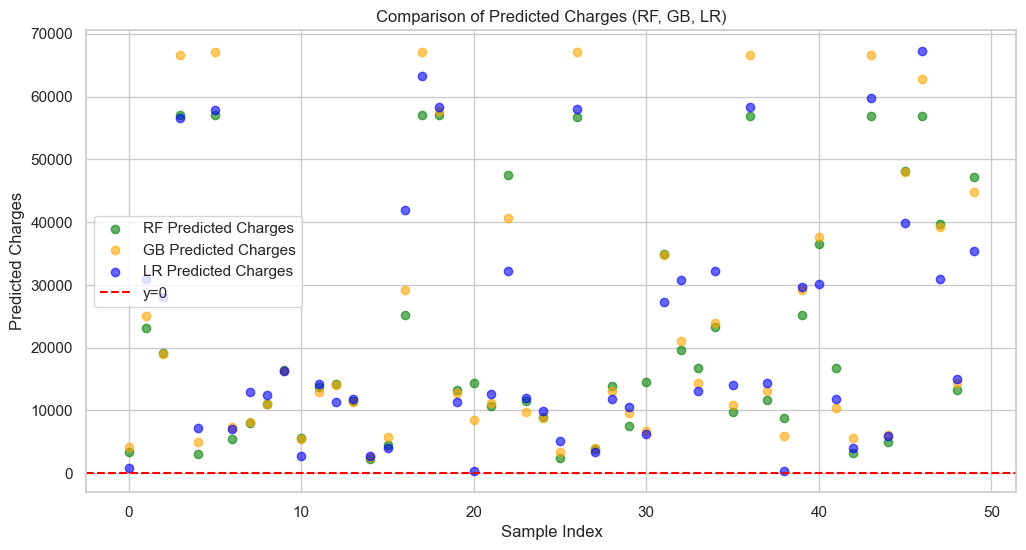

In [136]:
# Scatter plot to compare the predicted charges for all three models with y=0 line
plt.figure(figsize=(12, 6))

plt.scatter(range(len(y_pred_val_rf)), y_pred_val_rf, alpha=0.6, label='RF Predicted Charges', color='green')
plt.scatter(range(len(y_pred_val_gb)), y_pred_val_gb, alpha=0.6, label='GB Predicted Charges', color='orange')
plt.scatter(range(len(y_pred_val_lr)), y_pred_val_lr, alpha=0.6, label='LR Predicted Charges', color='blue')

# Draw a red dashed line at y=0
plt.axhline(y=0, color='red', linestyle='--', label='y=0')

plt.title('Comparison of Predicted Charges (RF, GB, LR)')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Charges')
plt.legend()
plt.show()

## Conclusion

- Consistency: Both the Random Forest and Gradient Boosting models produce consistent predictions across the sample indices, indicating they are capturing the underlying patterns well.
- Variation: The Linear Regression model shows more variation in predictions, suggesting it may not be capturing the complexities of the data as effectively as the other two models.
- The negative predicted charges from the Linear Regression model are associated with:
    - Younger ages.
    - Low BMI.
    - Male non-smokers.
    - Specific regions (Northwest and Southeast).

    These findings suggest that the Linear Regression model might not be capturing the relationship between these features and the charges accurately, leading to unrealistic negative predictions.